### Clustering with K-Means
In this notebook, we classify members based on their progressive scores from progressivepunch.com and govtrack.us.
They estimate how politically left or right a member is based on their views and voting on polarized ideologies.

The clustering algorithm is K-means, and the expected output should rank members as far left,  left-centrists, centrists, right-centrists, and far-right extremists.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [8]:
# read dfs
# Joining the cleaned tweets with the handles to get progressive scores

twttr_df = pd.read_csv("handles_scores.csv")
clean_df = pd.read_csv("clean_tweets.csv")

In [9]:
clean_df.head(2)

,tweet_id,username,party,tweet,clean_text,favorite_count,retweet_count,created_at,source,social_policy,geopolitical_policy,policies,policy
0,1453097115664662536,RepMikeGarcia,R,I joined fellow China Task Force lawmakers in ...,joined fellow china task force lawmakers in s...,43,29,2021-10-26 20:32:04+00:00,Twitter Web App,NaN,Geo Political Policies,"['Chinese Communist Party', '']",Chinese Communist Party
1,1511713375218245640,RepGallagher,R,"Rep. Gallagher: ""If we do not invest in hard p...",rep gallagher if we do not invest in hard powe...,25,11,2022-04-06 14:32:09+00:00,Twitter Web App,NaN,Geo Political Policies,"['Chinese Communist Party', 'Taiwan', 'Ukraine...",Ukraine Russia


In [10]:
twttr_df.head(5)

,name,name_punch,name_gov,Twitter Handle,St/Dis,Party,progressive_score,state_tilt,rank,score
0,"Adams, Alma","Adams, Alma","Adams, Alma",RepAdams,NC12,D,96.91,Strong Dem,#372,0.22
1,"Aderholt, Robert","Aderholt, Robert","Aderholt, Robert",Robert_Aderholt,AL04,R,5.96,Strong Rep,#146,0.65
2,"Aguilar, Pete","Aguilar, Pete","Aguilar, Pete",RepPeteAguilar,CA31,D,92.43,Strong Dem,#296,0.30
3,"Allen, Rick","Allen, Rick","Allen, Rick",RepRickAllen,GA12,R,0.64,Strong Rep,#26,0.82
4,"Allred, Colin","Allred, Colin","Allred, Colin",RepColinAllred,TX32,D,95.00,Leans Dem,#217,0.44


In [11]:
# Joining the cleaned tweets with the handles to get progressive scores

df = clean_df.merge(
    twttr_df[
        [
            "Twitter Handle",
            "Party",
            "name_punch",
            "name_gov",
            "progressive_score",
            "state_tilt",
            "rank",
            "score",
        ]
    ],
    left_on=["username", "party"],
    right_on=["Twitter Handle", "Party"],
    how="left",
)
df.drop(["Twitter Handle", "Party"], axis=1, inplace=True)

df.head(3)

,tweet_id,username,party,tweet,clean_text,favorite_count,retweet_count,created_at,source,social_policy,geopolitical_policy,policies,policy,name_punch,name_gov,progressive_score,state_tilt,rank,score
0,1453097115664662536,RepMikeGarcia,R,I joined fellow China Task Force lawmakers in ...,joined fellow china task force lawmakers in s...,43,29,2021-10-26 20:32:04+00:00,Twitter Web App,NaN,Geo Political Policies,"['Chinese Communist Party', '']",Chinese Communist Party,"Garcia, Mike","Garcia, Mike",8.67,Leans Dem,#218,0.44
1,1511713375218245640,RepGallagher,R,"Rep. Gallagher: ""If we do not invest in hard p...",rep gallagher if we do not invest in hard powe...,25,11,2022-04-06 14:32:09+00:00,Twitter Web App,NaN,Geo Political Policies,"['Chinese Communist Party', 'Taiwan', 'Ukraine...",Ukraine Russia,"Gallagher, Mike","Gallagher, Mike",6.03,Strong Rep,#52,0.76
2,1381021863313350658,RepDLesko,R,"CBP is currently encountering over 5,000 peopl...",cbp is currently encountering over 000 people ...,283,82,2021-04-10 23:10:45+00:00,Twitter for iPhone,Social Policies,NaN,"['Immigration and Border Control', '']",Immigration and Border Control,"Lesko, Debbie","Lesko, Debbie",1.65,Strong Rep,#7,0.91


## K-Means Clustering

In [12]:
from sklearn.cluster import KMeans

#### Clustering based on GovTrack scores

In [13]:
df_not_na = df[~(df.score.isna() | df.progressive_score.isna())]

# clustering based on govtrack scores
X1 = df_not_na[["score"]].iloc[:, :].values
inertia = []
for n in range(1, 11):
    algorithm = KMeans(
        n_clusters=n,
        tol=0.0001,
        random_state=111,
        algorithm="lloyd",
    )
    try:
        algorithm.fit(X1)
    except:
        pass
    inertia.append(algorithm.inertia_)

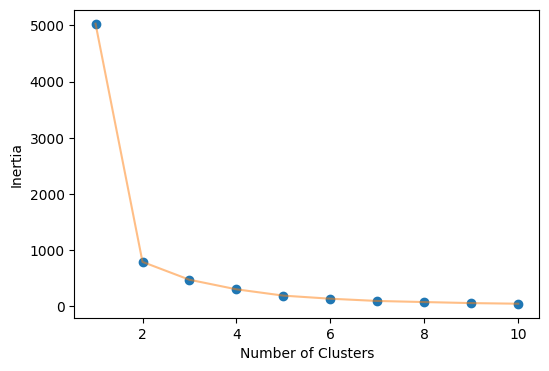

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, 11), inertia, "o")
plt.plot(np.arange(1, 11), inertia, "-", alpha=0.5)
plt.xlabel("Number of Clusters"), plt.ylabel("Inertia")
plt.show()

In [15]:
# initialize with 5 clusters

algorithm = KMeans(
    n_clusters=5,
    tol=0.0001,
    random_state=111,
    algorithm="lloyd",
)

algorithm.fit(X1)

KMeans(n_clusters=5, random_state=111)

In [16]:
# centroids of the clusters

centroids = algorithm.cluster_centers_
centroids

array([[0.11972604],
       [0.67916606],
       [0.39098105],
       [0.83236866],
       [0.25676991]])

In [17]:
# sort the labels based on centroid values e.g. lowest -> 0, highest -> 4
# this is useful in making the plots

# create a look up table
idx = np.argsort(algorithm.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)

lut[idx] = np.arange(5)

In [18]:
# create a govtrack cluster category in the dataframe


df_not_na["govtrack_cluster"] = lut[algorithm.labels_]

/tmp/ipykernel_43922/372910235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_na["govtrack_cluster"] = lut[algorithm.labels_]


#### Cluster based on Progressivepunch scores

In [19]:
# clustering based on progressive scores scores
X1 = df_not_na[["progressive_score"]].iloc[:, :].values

# initialize with 5 clusters

algorithm = KMeans(
    n_clusters=5,
    tol=0.0001,
    random_state=111,
    algorithm="lloyd",
)

algorithm.fit(X1)

# sort the labels based on centroid values e.g. lowest -> 0, highest -> 4
# this is useful in making the plots

# create a look up table
idx = np.argsort(algorithm.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)

lut[idx] = (np.arange(5))[::-1]

# create a govtrack cluster category in the dataframe

df_not_na["progressive_cluster"] = lut[algorithm.labels_]

/tmp/ipykernel_43922/3054659862.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_na["progressive_cluster"] = lut[algorithm.labels_]


In [21]:
# create labels from gov_track categories

# cluster labels
labels = np.arange(5)
label_names = ["Far Right", "Right Centrist", "Centrist", "Left Centrist", "Far Left"][
    ::-1
]

df_not_na["govtrack_class"] = df_not_na.govtrack_cluster.apply(
    lambda x: (dict(map(lambda i, j: (i, j), labels, label_names)))[x]
)

/tmp/ipykernel_43922/1960629483.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_na["govtrack_class"] = df_not_na.govtrack_cluster.apply(


In [23]:
df_not_na.to_csv("tweets_scores.csv", index=False)